Credit: Most of the notebook is developed from Dr. Joseph Capriotti's github repository:

https://github.com/jcapriot/gpgn-319

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0
from pathlib import Path
import pandas as pd

import em_utils.tdem_sounding as tdem_sounding
from simpeg.electromagnetics import time_domain as tdem
%matplotlib widget

## Reading WALKTEM data

Data have been converted to xlsx format to simplify the data io

In [16]:
file_name = 'data/processed_TDEM_data.xlsx'
df = pd.read_excel(file_name)

In [17]:
df.head()

,Moment,Channel,1,3.195,5.195,7.195,9.195,11.195,13.195,15.195,...,1432.195,1800.195,2263.695,2847.195,3581.695,4506.695,5671.195,7136.695,8853.195,10753.195
0,1,0,-1.248961e-08,-3.209091e-08,-2.940260e-08,-7.648052e-09,3.867532e-09,2.197403e-10,-1.714286e-09,-5.274026e-09,...,-3.646753e-08,-2.515584e-08,-1.711688e-08,-1.214675e-08,-8.520779e-09,-6.266234e-09,-4.646753e-09,-3.735065e-09,NaN,NaN
1,1,0,-9.942857e-09,-2.681818e-08,-2.210390e-08,-2.197403e-09,4.790909e-09,5.274026e-09,2.197403e-10,-5.581818e-09,...,-3.687013e-08,-2.524675e-08,-1.759740e-08,-1.264156e-08,-9.223377e-09,-6.763636e-09,-4.749351e-09,-3.080519e-09,NaN,NaN
2,1,0,-8.457143e-09,-2.993506e-08,-2.540260e-08,-1.758442e-09,8.350649e-10,3.780519e-09,-1.625974e-09,-1.538961e-09,...,-3.662338e-08,-2.481818e-08,-1.714286e-08,-1.185195e-08,-8.394805e-09,-6.214286e-09,-4.270130e-09,-2.359740e-09,NaN,NaN
3,1,0,-5.696104e-09,-2.676623e-08,-2.044156e-08,-2.110390e-09,5.802597e-09,2.857143e-09,-2.329870e-09,-2.022078e-09,...,-3.638961e-08,-2.454545e-08,-1.755844e-08,-1.193766e-08,-8.419481e-09,-5.980519e-09,-4.016883e-09,-2.828571e-09,NaN,NaN
4,1,0,-1.029610e-08,-2.914286e-08,-2.685714e-08,-4.307792e-09,6.593506e-10,-3.516883e-10,-7.032468e-09,-3.736364e-09,...,-3.622078e-08,-2.425974e-08,-1.711688e-08,-1.158571e-08,-8.242857e-09,-5.576623e-09,-3.494805e-09,-2.375325e-09,NaN,NaN


Text(0, 0.5, 'Amplitude (volts/A/m^2)')

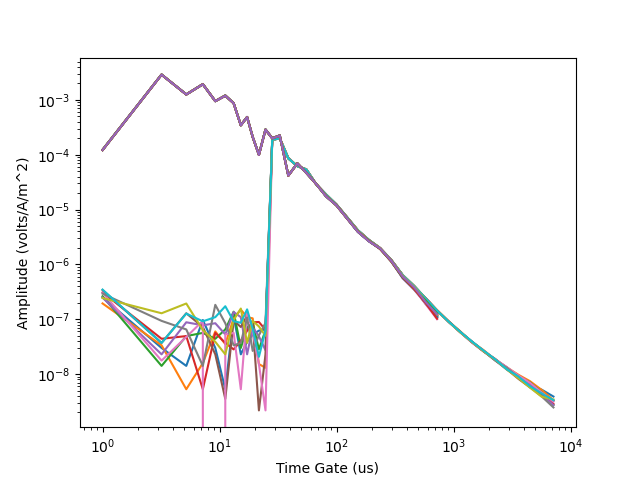

In [21]:
# example of extracting data for channel 1
time_gates = df.columns[2:].astype(float).values
chan = 1
moment = 1
data_ch1_M1 = df[(df['Channel'] == chan) & (df['Moment'] == moment)].iloc[:, 2:].values

chan = 1
moment = 2
data_ch1_M2 = df[(df['Channel'] == chan) & (df['Moment'] == moment)].iloc[:, 2:].values

plt.figure()
for i in range(0, data_ch1_M1.shape[0]):
    plt.loglog(time_gates, np.abs(data_ch1_M1[i, :]))

for i in range(0, data_ch1_M2.shape[0]):
    plt.loglog(time_gates, np.abs(data_ch1_M2[i, :]))

plt.xlabel('Time Gate (us)')
plt.ylabel('Amplitude (volts/A/m^2)')

## Question 1

> Plot data for both channels. The two channels are connected to the two receivers. Which channel is linked to the rigid receiver (the smaller one), and why?


Type your answer here:

## Question 2
> The two moments are corresponding to two currents: 7.7 amp and 1.0 amp. Which moment corresponds to the larger current? Why? 

Type your answer here:

## Clean up the data

In [9]:
data_M1_avg

NameError: name 'data_M1_avg' is not defined

In [ ]:
# Average the data for channel 1 and moment, remove the bad values
# four variables to define: M1_time_gates, M2_time_gates, M1_data_avg, M2_data_avg
# M1_time_gates: time gates for moment 1 (good values only, remove early time and nan values)
# M1_data_avg: averaged data for moment 1 (good values only, remove early time and nan values)
# M2_time_gates: time gates for moment 2 (good values only, remove early time and nan values)
# M2_data_avg: averaged data for moment 2 (good values only, remove early time and nan values)
# write your code here:


plt.figure()
plt.loglog(M1_time_gates, M1_data_avg, label='Moment 1')
plt.loglog(M2_time_gates, M2_data_avg, label='Moment 2')
plt.xlabel('Time Gate (us)')
plt.ylabel('Amplitude (volts/A/m^2)')
plt.legend()
plt.show()

Results should look like this:

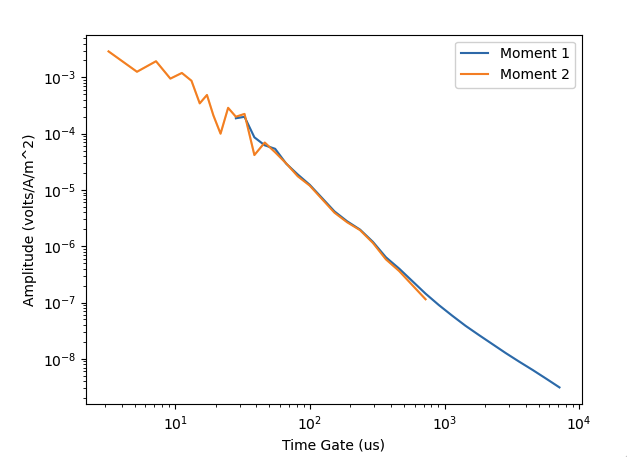

## Inversion

Now let's invert this data set!
* We start by setting up the simpeg survey object for this protem experience
* Compare this with how we set up the survey in our simple example before

In [38]:
### This sets up a simpeg survey for the ProTEM with the setup we used

# This is the shape of the 40 x 40 meter wire we used (Centered at 0)
tx_shape = np.array([
    [-20.0, -20.0, 0],
    [20.0, -20.0, 0],
    [20.0, 20.0, 0],
    [-20.0, 20.0, 0],
    [-20.0, -20.0, 0],
])

# This is different from before!
waveform = tdem.sources.PiecewiseLinearWaveform([-2.5E-6, 0],[1, 0])

# Two different receivers for each of the different gates seems like a good organization approach
M1_data = tdem.receivers.PointMagneticFluxTimeDerivative(
    locations=[0, 0, 0], times=M1_time_gates*1E-6, orientation='Z'
)
M2_data = tdem.receivers.PointMagneticFluxTimeDerivative(
    locations=[0, 0, 0], times=M2_time_gates*1E-6, orientation='Z'
)  

src = tdem.sources.LineCurrent(
    [M1_data, M2_data],
    location=tx_shape,
    waveform=waveform
    # moment=40*40
)
src.moment = 40 * 40

walktem_survey = tdem.Survey(src)

### Interactive inversion

* Now let's invert that data!
* Start up another interactive widget with passing observed values in.
* You can add layers, and drag the model parameters to check how it changes the data fitting. 
* click "Ran an inversion" button to perform the inversion.

A bit about this interactive widget:

* You can drag any of the lines to change their values
* You can insert a new node on any line by Shift+Right click (This inserts a new layer)
* You can drag the arrow downwards to give yourself more space to insert layers at the bottom
* If you pass observed_voltages to the constructor it will plot them as + on the right and enable the "Inversion" button.
* You can switch the right view window between volts and apparent conductivities
* Using the matplotlib controls:
    * The Home button returns you to the starting view
    * The Arrows will shift you between previous views
    * The box will zoom in on a "right click" selected square
    * The box will zoom out on a "left click" selected square
* You can retrieve the current model from the interactive widget using: cond, thick = walktem1.get_model()

In [39]:
walktem1 = tdem_sounding.TDEMSoundingInteract(
    walktem_survey,
    observed_voltage=np.r_[M1_data_avg, M2_data_avg])
walktem1.display()

In [42]:
cond, thick = walktem1.get_model()
print('Conductivity (S/m): ', cond)
print('Thickness (m): ', thick)

Conductivity (S/m):  [0.13185711 0.82409528]
Thickness (m):  [39.62213931]


## Question
>Screenshot and insert your inversion results for 1 layer (half space), 2, 3, and 4 layers models. Compare their data fitting errors (phi_d column)